In [81]:
from typstscribe.const import MODELS_DIR
import transformers
from datasets import Features, Image, Value, ClassLabel, load_dataset
from huggingface_hub import snapshot_download
from pathlib import Path
from typstscribe.image import convert_to_rgb_white_bg
import numpy as np
from typstscribe.typst import TypstGrayscaleCompiler
import evaluate

import PIL.Image as pil_image
import os
import torch
from joblib import Parallel, delayed

In [82]:
# Load models
model_default_path = MODELS_DIR / "run-default-one_stage-2025-12-04_19-52"
model_custom_path = MODELS_DIR / "run-2025-12-02_11-40"
model_path = model_default_path
# model_path = model_custom_path


processor = transformers.TrOCRProcessor.from_pretrained(model_path, use_fast=False)
model = transformers.VisionEncoderDecoderModel.from_pretrained(model_path)

model.to("cpu")

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
        

In [83]:
TEXT_COLUMN = "typst"  # Or "latex" if we wanted to do LaTeX OCR
MAX_LENGTH = 256

In [84]:
# Save a local copy of the entire dataset
dataset_path = Path(
    snapshot_download(
        repo_id="JeppeKlitgaard/typst-image-dataset",
        repo_type="dataset",
    )
)
display(dataset_path)

Fetching 354 files:   0%|          | 0/354 [00:00<?, ?it/s]

PosixPath('/home/jkl/.cache/huggingface/hub/datasets--JeppeKlitgaard--typst-image-dataset/snapshots/e855cf9b802ae2ac3b962f36f76f34977bd94155')

In [85]:
# Eval dataset
features = Features(
    {
        "image": Image(),
        "latex.txt": Value("string"),
        "typst.txt": Value("string"),
        "metadata.json": {
            "image_type": ClassLabel(names=["handwritten", "printed"]),
            "image_extension": ClassLabel(names=["png", "jpg", "bmp", "dvi"]),
        },
    }
)

ds = load_dataset(
    "JeppeKlitgaard/typst-image-dataset",
    data_files={
        # "test": "test/*.tar",
        "train": "train/shard_0001*.tar",
        "validation": "validation/*.tar",
    },
    # Maybe numproc here?
    features=features,
)
ds = ds.flatten()
ds = ds.rename_columns(
    {
        "typst.txt": "typst",
        "latex.txt": "latex",
        "metadata.json.image_type": "image_type",
        "metadata.json.image_extension": "image_extension",
    }
)
ds = ds.remove_columns(["image_extension"])

_target_image_type_int = features.flatten()["metadata.json.image_type"].str2int(
    "printed"
)


def filter_image_type(image_type_int):
    return image_type_int == _target_image_type_int


ds = ds.filter(
    filter_image_type,
    input_columns=["image_type"],
)  # Filter does not hydrate the class label apparently
ds = ds.remove_columns(["image_type"])
ds

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'latex', 'typst'],
        num_rows: 943190
    })
    validation: Dataset({
        features: ['image', 'latex', 'typst'],
        num_rows: 1366
    })
})

In [86]:
ds_eval = ds["validation"]

In [87]:
# Preprocessing the dataset
typst_compiler = TypstGrayscaleCompiler(ppi=100.0)


def preprocess_function(examples, render_typst: bool = False):
    N = len(examples["image"])
    images = [convert_to_rgb_white_bg(image) for image in examples["image"]]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values

    # Tokenize text
    labels = processor.tokenizer(
        examples[TEXT_COLUMN],
        padding="max_length",
        max_length=MAX_LENGTH,
        truncation=True,
    ).input_ids

    # Replace padding token id's of the labels by -100 so it's ignored by the loss
    labels_with_ignore_index = [
        [
            label if label != processor.tokenizer.pad_token_id else -100
            for label in label_example
        ]
        for label_example in labels
    ]

    if render_typst:
        typst_image = []
        is_good = [True] * N
        for i, typst_src in enumerate(examples[TEXT_COLUMN]):
            try:
                typst_image.append(typst_compiler.compile(typst_src))
            except Exception:
                print("GOT ERROR!")
                is_good[i] = False
                typst_image.append(None)
        return {
            "pixel_values": pixel_values,
            "labels": labels_with_ignore_index,
            "typst_image": typst_image,
            "raw_image": images,
            "is_good": is_good,
            "gt_typst": examples[TEXT_COLUMN]
        }

    return {"pixel_values": pixel_values, "labels": labels_with_ignore_index}


# Apply preprocessing
# We remove original columns to save memory and prevent collation errors
# num_proc = None --> 128 examples/s
column_names = ds_eval.column_names
ds_eval = ds_eval.map(
    preprocess_function,
    batched=True,
    num_proc=None,  # Setting this to an int seems not to work
    remove_columns=column_names,
    fn_kwargs={"render_typst": True},
    new_fingerprint="trocr_validation_preprocess_v7",
)


# Filter out any samples that have too many tokens
def filter_max_length(examples):
    label_array = np.array(examples["labels"])
    real_lengths = (label_array != -100).sum(axis=1)
    return real_lengths <= MAX_LENGTH

# Filter out eval samples where Typst rendering failed
def filter_typst_good(examples):
    is_good_array = np.array(examples["is_good"])
    return is_good_array

SHORT_SAMPLE_MAX_LENGTH = 100
def filter_short_samples_batched(examples):
    label_array = np.array(examples["labels"])
    real_lengths = (label_array != -100).sum(axis=1)
    return real_lengths <= SHORT_SAMPLE_MAX_LENGTH

# Apply the vectorized filter
ds_eval = ds_eval.filter(filter_max_length, batched=True)
ds_eval = ds_eval.filter(filter_typst_good, batched=True)
ds_eval = ds_eval.remove_columns(["is_good"])

# Lastly, cut down eval set because evals are expensive
ds_eval = ds_eval.select(range(128))
eval_small_dataset = ds_eval.select(range(8))

# Set format for PyTorch
# ds_train = ds_train.select_columns(["pixel_values", "labels"])
ds_eval.set_format(type="torch", columns=["pixel_values", "labels"], output_all_columns=True)  # Do not convert typst_image column
eval_small_dataset.set_format(type="torch", columns=["pixel_values", "labels"], output_all_columns=True)

Map:   0%|          | 0/1366 [00:00<?, ? examples/s]

GOT ERROR!
GOT ERROR!
GOT ERROR!


Filter:   0%|          | 0/1366 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1366 [00:00<?, ? examples/s]

In [88]:
ds_eval

Dataset({
    features: ['pixel_values', 'labels', 'typst_image', 'raw_image', 'gt_typst'],
    num_rows: 128
})

In [ ]:
# Eval metrics
cer_metric = evaluate.load("cer")


def calculate_iou(img_pred, img_gt):
    """
    Calculates IoU by placing images on a shared white canvas
    without resizing (scaling) them. Aligns images to the top-left.

    IoU is okay here because we are generating the images in the exact same manner.
    """
    img_pred = img_pred.convert("L")
    img_gt = img_gt.convert("L")

    # Get largest dimension for us to copy onto
    max_w = max(img_pred.width, img_gt.width)
    max_h = max(img_pred.height, img_gt.height)

    # White background
    canvas_pred = pil_image.new("L", (max_w, max_h), color=255)
    canvas_gt = pil_image.new("L", (max_w, max_h), color=255)

    canvas_pred.paste(img_pred, (0, 0))
    canvas_gt.paste(img_gt, (0, 0))

    # Binarize
    arr_pred = np.array(canvas_pred) < 128
    arr_gt = np.array(canvas_gt) < 128

    # IoU
    intersection = np.logical_and(arr_pred, arr_gt).sum()
    union = np.logical_or(arr_pred, arr_gt).sum()
    if union == 0:
        return 1.0

    return intersection / union


def visual_metrics_batch(batch_samples: list[tuple[str, pil_image.Image]]) -> list[tuple[bool, float]]:
    local_compiler = TypstGrayscaleCompiler(ppi=100.0)
    batch_results = []

    for pred_text, gt_img in batch_samples:
        try:
            pred_img = local_compiler.compile(pred_text)
            iou = calculate_iou(pred_img, gt_img)
            batch_results.append((True, iou))
        except Exception:
            batch_results.append((False, 0.0))

    return batch_results

num_cpu_cores = os.cpu_count() or 1
print(f"Detected {num_cpu_cores} CPU cores for parallel processing.")
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # TODO: Pred should already have gt_img column?

    # Replace -100 with pad_token_id for decoding
    pred_ids[pred_ids == -100] = processor.tokenizer.pad_token_id
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    ## Visual metrics
    # Prepare data for parallel processing
    ground_truth_images = ds_eval["typst_image"]
    all_samples = list(zip(pred_str, ground_truth_images))

    # Split into batches

    batch_size = len(all_samples) // num_cpu_cores + 1
    batches = [
        all_samples[i : i + batch_size]
        for i in range(0, len(all_samples), batch_size)
    ]

    # Run parallel jobs
    batch_results = Parallel(n_jobs=-1, backend="loky")(
        delayed(visual_metrics_batch)(batch) for batch in batches
    )

    # Flatten results
    results = [item for sublist in batch_results for item in sublist]

    # Calculate final metrics
    compilable_flags = [r[0] for r in results]
    iou_scores = [r[1] for r in results]

    total_preds = len(pred_str)
    ratio_compilable = sum(compilable_flags) / total_preds if total_preds > 0 else 0.0
    mean_iou = np.mean(iou_scores) if iou_scores else 0.0

    return {
        "cer": cer,
        "ratio_compilable": ratio_compilable,
        "iou_scores": mean_iou,
    }

Detected 18 CPU cores for parallel processing.


In [90]:
model

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
        

In [91]:
# Evaluate model on ds_eval
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers.trainer_utils import EvalPrediction

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

def collate_eval(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = pad_sequence(
        [item["labels"] for item in batch],
        batch_first=True,
        padding_value=processor.tokenizer.pad_token_id,
    )
    labels[labels == processor.tokenizer.pad_token_id] = -100
    typst_image = [item["typst_image"] for item in batch]
    return {"pixel_values": pixel_values, "labels": labels, "typst_image": typst_image,}

eval_loader = DataLoader(
    ds_eval,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_eval,
)

pred_sequences = []
label_sequences = []

with torch.no_grad():
    for batch in eval_loader:
        pixel_values = batch["pixel_values"].to(device)
        generated_ids = model.generate(
            pixel_values,
            max_length=MAX_LENGTH,
            num_beams=4,
        )
        pred_sequences.extend(generated_ids.cpu())
        label_sequences.extend(batch["labels"])

predictions = pad_sequence(
    pred_sequences,
    batch_first=True,
    padding_value=processor.tokenizer.pad_token_id,
).numpy()
labels = pad_sequence(
    label_sequences,
    batch_first=True,
    padding_value=-100,
).numpy()

metrics = compute_metrics(EvalPrediction(predictions=predictions, label_ids=labels))
print(metrics)

{'cer': 0.7466276059408639, 'ratio_compilable': 0.2421875, 'iou_scores': np.float64(0.01812379113484058)}


In [97]:
# Try a single sample
sample_example = ds_eval[0]
sample_example["raw_image"]
sample_example["typst_image"]
pixel_values = processor(images=sample_example["raw_image"], return_tensors="pt").pixel_values.to(
    model.device
)
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(generated_text)
# with torch.no_grad():
#     model.generate(sample_example["pixel_values"].to(device))


|(( ) | ( ) et _ 4


In [96]:
ds_eval["gt_typst"][0]

'| bold( upright( u ) ) | _ ( 1 ) < eta _ ( 4 )'

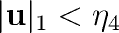

In [99]:
ds_eval[0]["raw_image"]